##Χρήση augmentation τεχνικών που βρέθηκαν από το AutoAugment για το dataset CIFAR10

In [0]:
!pip install Pillow==6.2.0

In [2]:
import torch, numpy as np
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt

BATCH_SIZE = 16

# A couple of augmentation techniques tried on cifar from scratch. They serve no purpose in this demo
#def smoothen(img):
#  scale = (3,3)
#  return cv2.GaussianBlur(np.asarray(img), scale, 0)

#def sharpen(img):
#  low = smoothen(img)
#  return cv2.addWeighted(np.asarray(img),3,low,-2,0)

#train_transforms = transforms.Compose([transforms.RandomApply([transforms.Lambda(sharpen)], 0.3), transforms.ToTensor()])
test_transforms = transforms.ToTensor()

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=True, download=True,
                       transform=test_transforms),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=False, download=True,
                       transform=test_transforms),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
len(train_loader)*BATCH_SIZE
img, label = list(train_loader)[1]

In [0]:
label_to_class = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

Οπτικοποίηση ορισμένων εικόνων του CIFAR10

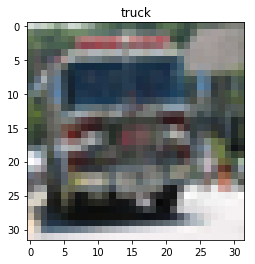

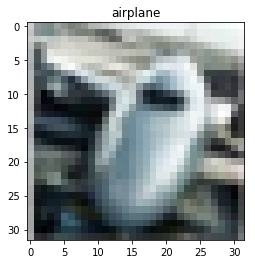

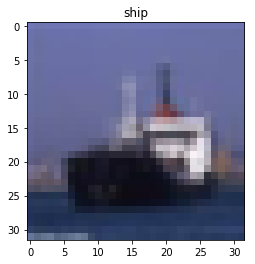

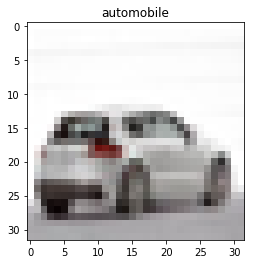

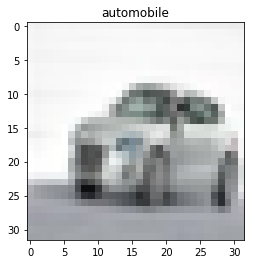

In [5]:
for i in range(5):
  image = img[i, :, :, :].numpy()
  plt.imshow(image.transpose(1, 2, 0))
  plt.title(label_to_class[label[i].item()])
  plt.show()

Ορίζουμε παρακάτω το απλό CNN δίκτυο που θα χρησιμοποιήσουμε στο πέιραμα μας

In [0]:
import torch.nn as nn
import torch.nn.functional as functions
import torch.optim as optim

class Cyclops(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Cyclops, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.convolutional_layer1 = nn.Sequential(nn.Conv2d(in_channels=self.input_dim, out_channels=12, kernel_size=4),
                               nn.ReLU(inplace=True),
                               nn.MaxPool2d(kernel_size=4))
    
    self.convolutional_layer2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=24, kernel_size=4),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=4))
    
    self.classifier_layer = nn.Linear(24, self.output_dim)
  
  def forward(self, x):
    x = self.convolutional_layer1(x)
    x = self.convolutional_layer2(x)
    x = x.view(BATCH_SIZE, -1)
    return self.classifier_layer(x)

input_dim = 3 #number of channels
output_dim = 10 #number of classes
n_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Cyclops(input_dim, output_dim).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch, train_data, model):
  model.train()
  for batch_idx, (data, target) in enumerate(train_data):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 480 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_data.dataset),
        100. * batch_idx / len(train_data), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_data.dataset)))
      
      
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Αρχικά εκπαιδεύουμε το δίκτυο μας για 5 εποχές με τα πραγματικά δεδομένα.

In [8]:
print("Baseline score")
test(model)
for epoch in range(1, n_epochs + 1):
  train(epoch, train_loader, model)
  test(model)

Baseline score

Test set: Avg. loss: 0.1441, Accuracy: 1001/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.337534
Train Epoch: 1 [7680/50000 (15%)]	Loss: 3.377643
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.924010
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.870247
Train Epoch: 1 [30720/50000 (61%)]	Loss: 2.017515
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.813033
Train Epoch: 1 [46080/50000 (92%)]	Loss: 1.954940

Test set: Avg. loss: 0.1066, Accuracy: 3964/10000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.843747
Train Epoch: 2 [7680/50000 (15%)]	Loss: 1.402459
Train Epoch: 2 [15360/50000 (31%)]	Loss: 1.298182
Train Epoch: 2 [23040/50000 (46%)]	Loss: 1.345532
Train Epoch: 2 [30720/50000 (61%)]	Loss: 1.522247
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.722005
Train Epoch: 2 [46080/50000 (92%)]	Loss: 1.411588

Test set: Avg. loss: 0.0968, Accuracy: 4370/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.250652
Train Epoch: 3 [7680/50000 (15%)]	Loss: 1.357542
Train Epoch: 3 [15360/50000 (

Στη συνέχεια ορίζουμε τις 5 βέλτιστες πολιτικές που βρέθηκαν από το AutoAugment πως βοηθούν στη γενίκευση δικτύων για το CIFAR10. Παρατηρούμε την πολλαπλή εμφάνιση χρωματικών μετασχηματισμών, όπως το equalize, color και autocontrast. Ο παρακάτω κώδικας που ορίζει τους βέλτιστους μετασχηματισμούς χρησιμοποιήθηκε από το εξής repository: https://github.com/DeepVoltaire/AutoAugment/blob/master/autoaugment.py

In [0]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random

class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

In [10]:
aa_transforms = transforms.Compose([CIFAR10Policy(), transforms.ToTensor()])

train_loader_aa = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=True, download=True,
                       transform=aa_transforms),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified


Τρέξτε πολλές φορές το παρακάτω κελί για παραγωγή διάφορων εικόνων από το augmented dataset.

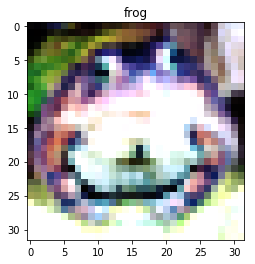

In [11]:
img, label = next(iter(train_loader_aa))
image = img[0, :, :, :].numpy()
plt.imshow(image.transpose(1, 2, 0))
plt.title(label_to_class[label[0].item()])
plt.show()

Δοκιμάζουμε να συνεχίσουμε την εκπαίδευση του παραπάνω δικτύου για λίγες ακόμα εποχές με τα augmented δεδομένα αυτή τη φορά. Χαμηλώνουμε κατά μία τάξη μεγέθους το ρυθμό μάθησης του gradient descent, ώστε οι αλλαγές που κάνουμε στα βάρη του δικτύου να είναι σχετικά χαμηλές (finetuning), μιας και έχει ολοκληρωθεί η βασική εκπαίδευση του δικτύου.

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_aa.dataset) for i in range(n_epochs + 1)]

test(model)
for epoch in range(1, n_epochs + 1):
  train(epoch, train_loader_aa, model) # train with augmented dataset
  test(model)


Test set: Avg. loss: 0.0887, Accuracy: 5026/10000 (50%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.739655
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.626369
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.532088
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.247480
Train Epoch: 1 [30720/50000 (61%)]	Loss: 1.356761
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.462374
Train Epoch: 1 [46080/50000 (92%)]	Loss: 1.453137

Test set: Avg. loss: 0.0827, Accuracy: 5447/10000 (54%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.955487
Train Epoch: 2 [7680/50000 (15%)]	Loss: 1.445154
Train Epoch: 2 [15360/50000 (31%)]	Loss: 1.474421
Train Epoch: 2 [23040/50000 (46%)]	Loss: 2.065754
Train Epoch: 2 [30720/50000 (61%)]	Loss: 1.795799
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.402309
Train Epoch: 2 [46080/50000 (92%)]	Loss: 1.534110

Test set: Avg. loss: 0.0813, Accuracy: 5523/10000 (55%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.763641
Train Epoch: 3 [7680/50000 (15%)]	Loss: 1.575195
Train Epoch: 3 [15360/50000 (31%)]	Loss: 2.1

Παρατηρούμε πως ακόμα και στην μικρή αυτή αρχιτεκτονική, η χρήση augmented δεδομένων βοήθησε το δίκτου να γενικεύσει καλύτερα και πιθανώς η χρήση augmented δεδομένων μετά τη βασική εκπαίδευση ενός δικτύου να αποτελεί ένα καλό τρόπο για ένα επιπλέον regularization των παραμέτρων μοντέλου.